In [1]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt
import os
from rasterio.enums import Resampling

Check radiation components


**Table of contents**<a id='toc0_'></a>    
- [PRISM UCRB Temperature](#toc1_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
era5_land_net_rad = xr.open_dataset('../data/etdata/ERA5-net-radiation/era5-radiation-components.nc')

In [3]:
era5_land_net_rad['ssru'] = era5_land_net_rad['ssrd'] - era5_land_net_rad['ssr']
era5_land_net_rad['stru'] = era5_land_net_rad['strd'] - era5_land_net_rad['str']

In [4]:
era5_clouds = xr.open_dataset('../data/etdata/ERA5_pet_et_clouds.nc')
era5_clouds_ex = era5_clouds.sel(longitude=-107, latitude=39, method='nearest')
# calculate monthly anomalies in cloud cover
monthly_mean = era5_clouds_ex['tcc'].groupby('time.month').mean('time')
monthly_std = era5_clouds_ex['tcc'].groupby('time.month').std('time')
era5_clouds_ex['tcc_anom'] = (era5_clouds_ex['tcc'].groupby('time.month') - monthly_mean) / monthly_std

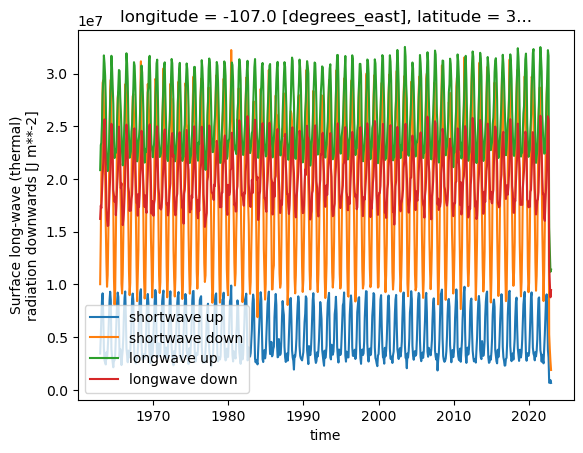

In [5]:
example = era5_land_net_rad.sel(longitude=-107, latitude=39, method='nearest')
example_monthly_mean = example.groupby('time.month').mean()
example_monthly_std = example.groupby('time.month').std()
example_anom = example.copy()
example_anom['strd_anom'] = (example['strd'].groupby('time.month') - example_monthly_mean['strd']) / example_monthly_std['strd']
example_anom['ssrd_anom'] = (example['ssrd'].groupby('time.month') - example_monthly_mean['ssrd']) / example_monthly_std['ssrd']
example_anom['stru_anom'] = (example['stru'].groupby('time.month') - example_monthly_mean['stru']) / example_monthly_std['stru']
example_anom['ssru_anom'] = (example['ssru'].groupby('time.month') - example_monthly_mean['ssru']) / example_monthly_std['ssru']
example['ssru'].plot(label='shortwave up')
example['ssrd'].plot(label='shortwave down')
example['stru'].plot(label='longwave up')
example['strd'].plot(label='longwave down')
plt.legend()

Text(0, 0.5, 'monthly upwelling shortwave radiation anomaly')

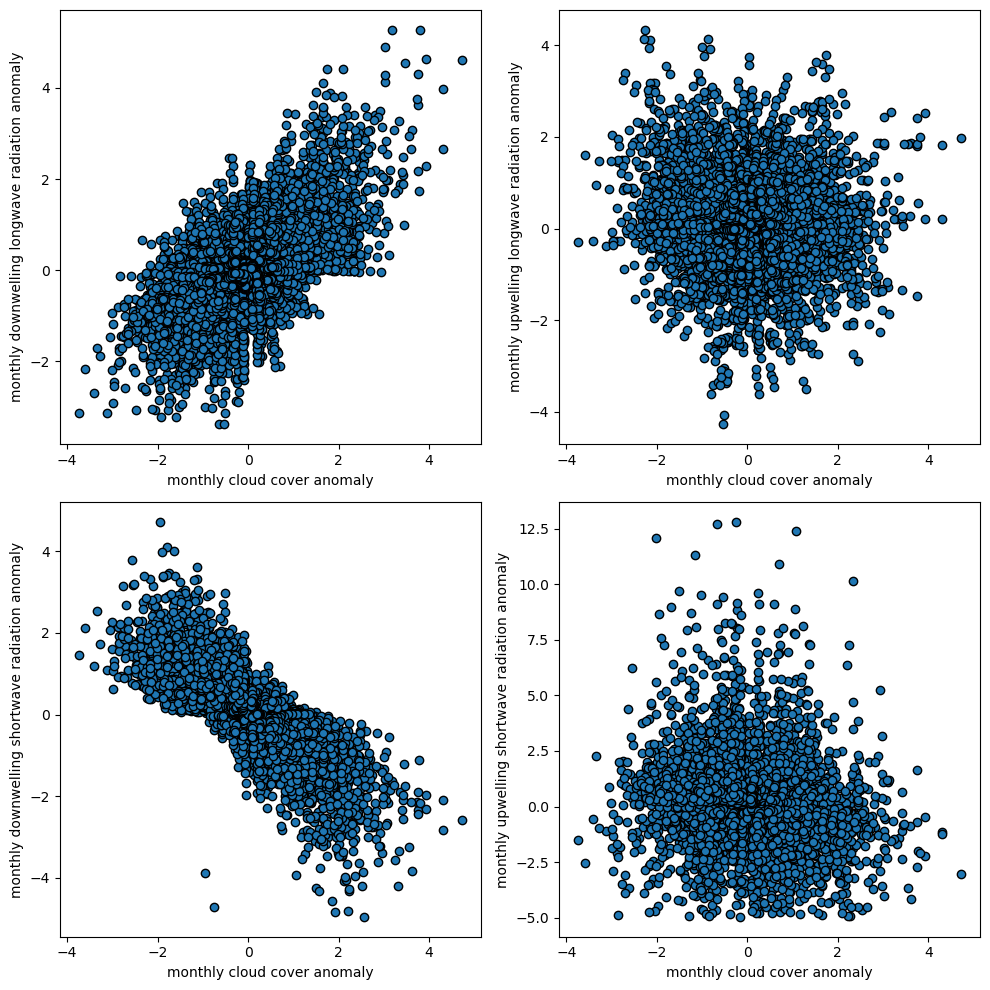

In [6]:
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(10, 10))   
axs[0, 0].scatter(era5_clouds_ex.where(example_anom['strd_anom']>-5)['tcc_anom'], example_anom.where(example_anom['strd_anom']>-5)['strd_anom'], ec='k')
axs[0, 0].set_xlabel('monthly cloud cover anomaly')
axs[0, 0].set_ylabel('monthly downwelling longwave radiation anomaly')
axs[1, 0].scatter(era5_clouds_ex.where(example_anom['ssrd_anom']>-5)['tcc_anom'], example_anom.where(example_anom['ssrd_anom']>-5)['ssrd_anom'], ec='k')
axs[1, 0].set_xlabel('monthly cloud cover anomaly')
axs[1, 0].set_ylabel('monthly downwelling shortwave radiation anomaly')
axs[0, 1].scatter(era5_clouds_ex.where(example_anom['stru_anom']>-5)['tcc_anom'], example_anom.where(example_anom['stru_anom']>-5)['stru_anom'], ec='k')
axs[0, 1].set_xlabel('monthly cloud cover anomaly')
axs[0, 1].set_ylabel('monthly upwelling longwave radiation anomaly')
axs[1, 1].scatter(era5_clouds_ex.where(example_anom['ssru_anom']>-5)['tcc_anom'], example_anom.where(example_anom['ssru_anom']>-5)['ssru_anom'], ec='k')
axs[1, 1].set_xlabel('monthly cloud cover anomaly')
axs[1, 1].set_ylabel('monthly upwelling shortwave radiation anomaly')

Text(0, 0.5, 'Albedo or fSCA')

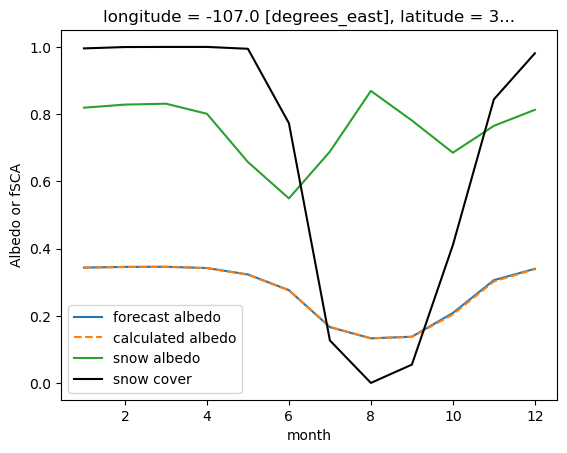

In [7]:
monthly_example = example.groupby('time.month').mean()
monthly_example['fal'].plot(label = 'forecast albedo')
(monthly_example['ssru']/monthly_example['ssrd']).plot(label='calculated albedo', ls='--')
monthly_example['asn'].plot(label = 'snow albedo')
(monthly_example['snowc']/100).plot(label='snow cover', color='k')
plt.legend()
plt.xlabel('month')
plt.ylabel('Albedo or fSCA')

But why is low elevation PET greater in the wet year than the dry year?  I thought the wet year was cloudier, which is less incoming radiation regardless of surface albedo.

Should probably check 

a) net radiation products vs b) net radiation that you calculate with changed snow albedo (0.8 goes to 0.2) per fSCA  

c) PET with those two net radiations vs your PET with 0 PET where there’s snow

2.  You are using net radiation products.  How do these products calculate incoming and outgoing radiation, and do they consider forest cover at all?

2.  You could do your own forest sensitivity tests, but first step is you should be fully aware of how each of your net radiation products comes up with its numbers.

Calculate energy only PET

In [8]:
era5_energy_only = era5_land_net_rad
era5_energy_only = era5_energy_only.rename({'latitude': 'y', 'longitude': 'x'})
# add crs to the data
era5_energy_only = era5_energy_only.rio.write_crs("epsg:4326")
# open ucrb boundary
ucrb = gpd.read_file('../data/geodata/Upper_Colorado_River_Basin_Boundary.json')
# clip era5 data to ucrb
era5_energy_only_clipped = era5_energy_only.rio.clip(ucrb.geometry, crs=ucrb.crs)
# sort by time
era5_energy_only_clipped = era5_energy_only_clipped.sortby('time')
# add days per month to the data
era5_energy_only_clipped['days_per_month'] = era5_energy_only_clipped.time.dt.days_in_month
# convert J/m2 to W/m2
era5_energy_only_clipped['ssr'] = era5_energy_only_clipped.ssr / (3600 * 24 )
era5_energy_only_clipped['str'] = era5_energy_only_clipped.str / (3600 * 24 )
era5_energy_only_clipped['ssrd'] = era5_energy_only_clipped.ssrd / (3600 * 24 )
era5_energy_only_clipped['strd'] = era5_energy_only_clipped.strd / (3600 * 24 )
era5_energy_only_clipped['ssru'] = era5_energy_only_clipped.ssru / (3600 * 24 )
era5_energy_only_clipped['stru'] = era5_energy_only_clipped.stru / (3600 * 24 )
era5_energy_only_clipped['rnet_no_change'] = (era5_energy_only_clipped['ssrd'] - era5_energy_only_clipped['ssru']) + (era5_energy_only_clipped['strd'] - era5_energy_only_clipped['stru'])
era5_energy_only_clipped['ssr_adj'] = (era5_energy_only_clipped['ssrd'] - 0.8*(era5_energy_only_clipped['ssrd']))
era5_energy_only_clipped['ssr_adj'] =  era5_energy_only_clipped['ssr_adj'].where(era5_energy_only_clipped['snowc'] > 50, 
                                                                                 era5_energy_only_clipped['ssrd'] - 0.2*(era5_energy_only_clipped['ssrd']))
era5_energy_only_clipped['rnet_adj'] = (era5_energy_only_clipped['ssr_adj'] + era5_energy_only_clipped['str'])
# set negative values to 0
era5_energy_only_clipped['rnet_adj'] = era5_energy_only_clipped['rnet_adj'].where(era5_energy_only_clipped['rnet_adj'] > 0, 0)

# for all cells with snow cover over 50, set PET to 0
era5_energy_only_clipped['rnet_zero'] = (era5_energy_only_clipped['ssr'] + era5_energy_only_clipped['str'])
era5_energy_only_clipped['rnet_zero'] = era5_energy_only_clipped['rnet_zero'].where((era5_energy_only_clipped['snowc'] >=0) & (era5_energy_only_clipped['snowc'] <50), 0)
# clip values to ucrb boundary
era5_energy_only_clipped = era5_energy_only_clipped.rio.clip(ucrb.geometry, crs=ucrb.crs)

In [74]:
# energy only et 
rho = 1000
L = 2.5e6
era5_energy_only_clipped['et_eo'] = (0.8*86400*1000*era5_energy_only_clipped['rnet_no_change'] / (rho * L)) * era5_energy_only_clipped.days_per_month
era5_energy_only_clipped['et_eo_adj'] = (0.8*86400*1000*era5_energy_only_clipped['rnet_adj'] / (rho * L)) * era5_energy_only_clipped.days_per_month
era5_energy_only_clipped['et_eo_zero'] = (0.8*86400*1000*era5_energy_only_clipped['rnet_zero'] / (rho * L)) * era5_energy_only_clipped.days_per_month
# save to netcdf
era5_energy_only_clipped.to_netcdf('../data/etdata/ERA5_energy_only_clipped.nc')

In [10]:
# open hcdn basins
hcdn_basins = gpd.read_file('../data/geodata/ucrb_selected_basins.geojson')
# convert to 4326
hcdn_basins = hcdn_basins.to_crs("epsg:4326")

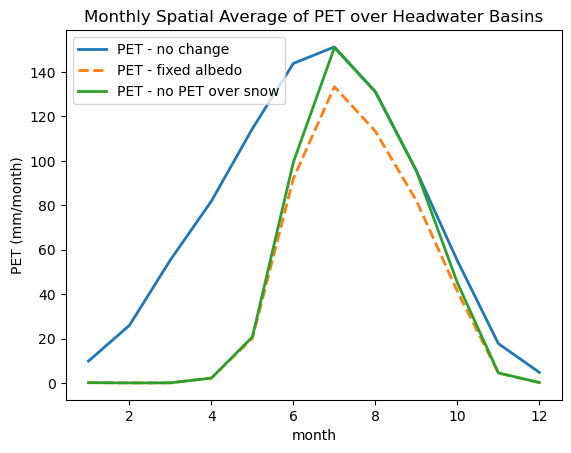

In [11]:
example = era5_energy_only_clipped.rio.clip(hcdn_basins.geometry, crs=hcdn_basins.crs).mean(dim=['x', 'y'])
example['et_eo'].groupby('time.month').mean().plot(label='PET - no change', lw=2)
example['et_eo_adj'].groupby('time.month').mean().plot(label='PET - fixed albedo', lw=2, ls='--')
example['et_eo_zero'].groupby('time.month').mean().plot(label='PET - no PET over snow', lw=2)
plt.ylabel('PET (mm/month)')
plt.title('Monthly Spatial Average of PET over Headwater Basins')
plt.legend()

Land-Cover

In [12]:
da = rxr.open_rasterio('../data/geodata/nlcd_landcover/nlcd_UCRB_4326.tif').squeeze()
# replace values less than 0 with nan
da = da.where(da>0, np.nan)

In [13]:
da_reproj = da.rio.reproject_match(era5_energy_only_clipped)
da_reproj_25 = da_reproj.where(da_reproj.isin([31]))
da_reproj_25 = da_reproj_25.where((da_reproj_25.x<-109) & (da_reproj_25.y<39))
da_reproj_10 = da_reproj.where(da_reproj.isin([51,52,71,72,73,74,81,82])) 
da_reproj_5 = da_reproj.where(da_reproj.isin([41,42,43,90,95]))

In [14]:
era5_net = (era5_energy_only_clipped.ssr + era5_energy_only_clipped.str)
era5_net = era5_net - 0.05 * (era5_net * da_reproj_5.notnull())
era5_net = era5_net - 0.1 * (era5_net * da_reproj_10.notnull())
era5_net = era5_net - 0.25 * (era5_net * da_reproj_25.notnull())
era5_net = era5_net.rename('net_radiation')
era5_net = era5_net.rio.write_crs("epsg:4326")

In [15]:
# load raw era5 data
era5_eo_clipped = xr.open_dataset('../data/etdata/ERA5-Land-PT-PET-vars.nc')
# add crs
era5_eo_clipped = era5_eo_clipped.rio.write_crs("epsg:4326")
# load cloud cover data from ERA5
era5_cc = xr.open_dataset('../data/etdata/ERA5_pet_et_clouds.nc').tcc
era5_cc = era5_cc.rio.write_crs(4326)
# rename latitudes and longitudes to x and y
era5_cc = era5_cc.rename({'latitude': 'y', 'longitude': 'x'})
# clip to ucrb
era5_cc = era5_cc.rio.clip(ucrb.geometry, crs=ucrb.crs)
era5_net_matched = era5_net#.rio.reproject_match(era5_cc)
era5_2m_temp = era5_eo_clipped['t2m'].rio.reproject_match(era5_cc)
era5_pet = era5_energy_only_clipped['et_eo']
# replace large values with nan
era5_net_matched = era5_net_matched.where(era5_net_matched < 100000, np.nan)

In [16]:
# get spring average era5_cc
era5_cc_spring = era5_cc.sel(time=era5_cc.time.dt.month.isin([3,4,5])).groupby('time.year').mean('time')

# get spring average era5_net
era5_net_spring = era5_net_matched.sel(time=era5_net_matched.time.dt.month.isin([3,4,5])).groupby('time.year').sum('time')
# get spring average era5_2m_temp
era5_2m_temp_spring = era5_2m_temp.sel(time=era5_2m_temp.time.dt.month.isin([3,4,5])).groupby('time.year').mean('time')
# get spring average era5_pet
era5_pet_spring = era5_pet.sel(time=era5_pet.time.dt.month.isin([3,4,5])).groupby('time.year').mean('time')

### <a id='toc1_1_1_'></a>[PRISM UCRB Temperature](#toc0_)

In [17]:
# Open PRISM temperature data
prism_tmean = rxr.open_rasterio('../data/etdata/prism_tmean_4km_ucrb.nc')
# reprject to match the UCRB boundary
prism_tmean = prism_tmean.rio.reproject(4326)
prism_tmean = prism_tmean.where(prism_tmean>-100,drop=True).sel(month=slice('1930-01-01','2022-09-30'))


In [18]:
# add the year as a new dimension to prism_tmean
prism_tmean = prism_tmean.assign_coords(year=prism_tmean['month'].dt.year)

# make a copy to use later
prism_tmean_copy = prism_tmean.copy()
prism_tmean_copy['month'] = prism_tmean_copy['month'].dt.year

In [19]:
# filter to treed areas (41,42,43)
treed_areas_fine = da.where(da.isin([41,42,43]),drop=True)
# untreed areas
untreed_areas = da.where(~da.isin([41,42,43]),drop=True)
# reproject tmean to match era5
treed_areas = treed_areas_fine.rio.reproject_match(era5_energy_only_clipped)
untreed_areas = untreed_areas.rio.reproject_match(era5_energy_only_clipped)
# make values less than 0 nan
treed_areas = treed_areas.where(treed_areas>=0,np.nan)
untreed_areas = untreed_areas.where(untreed_areas>=0,np.nan)

tmean = prism_tmean.rio.reproject_match(era5_energy_only_clipped)
# values less than 0 are nan
tmean = tmean.where(tmean>-1,np.nan)
# clip tmean by treed areas
tmean_treed = tmean.where(treed_areas.notnull(), np.nan)
# rename month to time
tmean_treed = tmean_treed.rename({'month':'time'})
# convert time to datetime64
tmean_treed['time'] = pd.to_datetime(tmean_treed['time'].values.astype('str'))

In [20]:
# pull in ucrb modis sca
ucrb_modis_sca_fine = xr.open_dataset('../data/snowdata/modis_sca/processed/ucrb_modis_sca.nc')
# add crs as 4326
ucrb_modis_sca = ucrb_modis_sca_fine.rio.write_crs(4326)
# resample to era5_land_ds grid
ucrb_modis_sca = ucrb_modis_sca.rio.reproject_match(era5_energy_only_clipped, resampling=Resampling.bilinear)

In [21]:
# resample to monthly mean
monthly_ucrb_modis_sca = ucrb_modis_sca.resample(time='1MS').mean()

# add crs
monthly_ucrb_modis_sca = monthly_ucrb_modis_sca.rio.write_crs(4326)
# reproject to match era5_energy_only_clipped
monthly_ucrb_modis_sca = monthly_ucrb_modis_sca.rio.reproject_match(era5_energy_only_clipped, resampling=Resampling.bilinear).sel(time=slice('2000-03-01','2016-06-01'))

# era5 subset
era5_subset = era5_energy_only_clipped.sel(time=slice('2000-03-01','2016-06-01'))
# where tmean treed is nan, set to 0
# era5_subset_tree_masked_1 = era5_subset.where(tmean_treed.sel(time=slice('2000-03-01','2016-06-01')).where(tmean_treed.time.dt.month.isin([3,4,5])).notnull().time,np.nan)
# add back in vlues not in the treed areas
# era5_subset_tree_masked_2 = era5_subset.where(untreed_areas.notnull(),np.nan)

# era5_subset_tree_masked = era5_subset_tree_masked_2.where(era5_subset_tree_masked_2.notnull(), era5_subset_tree_masked_1)
# select all cells where the sca is greater than 0.1
era5_subset_sca_masked = era5_subset.where(monthly_ucrb_modis_sca.where(monthly_ucrb_modis_sca.time.dt.month.isin([3,4,5])).Snow_Cover_Extent==0,0)


# replace values less than 0 with nan
era5_subset_masked = era5_subset_sca_masked.where(era5_subset_sca_masked>=0, np.nan)
# make all values outside the ucrb boundary np.nan
# era5_subset_masked = era5_subset_masked.rio.clip(ucrb_boundary_4326.geometry, all_touched=True)

In [22]:
# make a hypsometric plot of PET with elevation
era5_data = era5_subset.where(era5_subset.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time')
#era5_subset_masked.where(era5_subset_masked.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time')

# replace 0 with nan
era5_data = era5_data.where(era5_data>=0,np.nan)
# replace unrealistic values > 1000 with nan
# era5_data = era5_data.where((era5_data<900) | (~era5_data.notnull()),800)
# add the elevation data
dem_fine = rxr.open_rasterio('../data/geodata/ucrb_dem_32613_150m.tif').squeeze()
# calculate the area of 100 m elevation bins
dem_area = dem_fine.copy()
dem_area.name='elevation'
# convert to dataset
dem_area = dem_area.to_dataset()
dem_area = dem_area.rio.reproject_match(era5_data, resampling=Resampling.bilinear)
dem_area = dem_area.where(dem_area>0,np.nan)
# convert dem resolution to meters
area = np.full_like(dem_area.squeeze().to_array()[0], 10130.37725989001 * 10130.37725989001)
# add the area of each grid cell to the dataset
dem_area['area'] = xr.DataArray(area, coords=dem_area.coords)


# reproject to match era5
dem = dem_fine.rio.reproject_match(era5_data)
# make values less than 0 nan
dem = dem.where(dem>0,np.nan)
# add the elevation data to the era5 data
era5_data['elevation'] = dem
# add elevation to treed areas
if type(treed_areas_fine) != xr.core.dataset.Dataset:
    treed_areas_fine.name = 'tree_cover'
    treed_areas_fine = treed_areas_fine.to_dataset()
dem_tree = dem_fine.rio.reproject_match(treed_areas_fine, resampling=Resampling.bilinear)
treed_areas_fine['elevation'] = dem_tree
treed_areas_fine['tree_cover'] = treed_areas_fine['tree_cover'].where(treed_areas_fine['tree_cover'].notnull(),0)
treed_areas_fine['tree_cover'] = treed_areas_fine['tree_cover'].where(treed_areas_fine['tree_cover']==0,1)

In [23]:
# resample to monthly mean
monthly_ucrb_modis_sca_fine = ucrb_modis_sca_fine.resample(time='1MS').mean()

In [24]:
# get ready to plot modis SCA
spring_modis_sca = monthly_ucrb_modis_sca_fine.where(monthly_ucrb_modis_sca_fine.time.dt.month.isin([3,4,5]), drop=True).groupby('time.year').mean()

# add dem to modis sca
dem_sca = dem_fine.rio.reproject_match(spring_modis_sca)
# replace values less than 0 with nan
dem_sca = dem_sca.where(dem_sca>0, np.nan)
spring_modis_sca['elevation'] = dem_sca

In [25]:
tree_covered_area = rxr.open_rasterio('../data/geodata/nlcd_landcover/ucrb_tree_cover_fraction_cleaned.tif').squeeze()
# resample to 150 m resolution
tree_covered_area = tree_covered_area.rio.reproject_match(dem_fine, resampling=Resampling.bilinear)

# crop to ucrb
tree_covered_area = tree_covered_area.rio.clip(ucrb.to_crs(32613).geometry, all_touched=True)
# replace values above 100 with nan
tree_covered_area = tree_covered_area.where(tree_covered_area<=100,np.nan)
# convert to dataset and name 
tree_covered_area.name = 'tree_cover'
tree_covered_area = tree_covered_area.to_dataset()
# add the dem
tree_covered_area['elevation'] = dem_fine

In [26]:
tree_covered_area_bins = (tree_covered_area.groupby_bins('elevation', np.arange(tree_covered_area.elevation.min(),
                                  tree_covered_area.elevation.max(),
                                  100)).mean().tree_cover/100)

In [27]:
# add dem to net radiation
dem_era5_rnet = dem.rio.reproject_match(era5_net_matched) 
era5_net_matched_ds = era5_net_matched.to_dataset()
era5_net_matched_ds['elevation'] = dem_era5_rnet

# add dem to cloud cover
era5_cc_ds = era5_cc.to_dataset()
# rename latitude and longitude to y and x
era5_cc_ds['elevation'] = dem_era5_rnet

(75.0, 120.0)

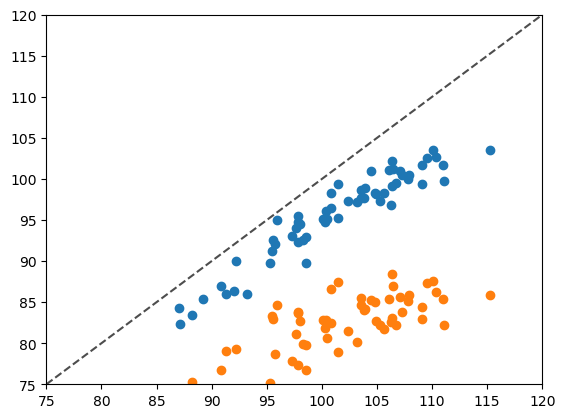

In [28]:
trees = tree_covered_area.rio.reproject_match(era5_net_matched_ds).tree_cover
trees = trees.where(trees<=100,np.nan)
high_tree_cover = trees.where(trees>10,np.nan)
low_tree_cover = trees.where((trees<=10) & (trees>0),np.nan)
no_tree_cover = trees.where(trees==0,np.nan)
era5_high_tree_cover = era5_net_matched_ds.where(high_tree_cover.notnull(),np.nan).where(era5_net_matched_ds.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').mean('time')
era5_low_tree_cover = era5_net_matched_ds.where(low_tree_cover.notnull(),np.nan).where(era5_net_matched_ds.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').mean('time')
era5_no_tree_cover = era5_net_matched_ds.where(no_tree_cover.notnull(),np.nan).where(era5_net_matched_ds.time.dt.month.isin([3,4,5]),drop=True).groupby('time.year').mean('time')
plt.scatter(era5_high_tree_cover.mean(dim=['x','y']).net_radiation,era5_low_tree_cover.mean(dim=['x','y']).net_radiation)
plt.scatter(era5_high_tree_cover.mean(dim=['x','y']).net_radiation,era5_no_tree_cover.mean(dim=['x','y']).net_radiation)
# plot 1:1 line
plt.plot([75, 120], [75, 120], ls="--", c=".3")
plt.xlim(75,120)
plt.ylim(75,120)

In [29]:
binned_rnet = era5_net_matched_ds.groupby_bins(era5_net_matched_ds.elevation, bins=np.arange(era5_net_matched_ds.elevation.min(),era5_net_matched_ds.elevation.max(),100)).mean().net_radiation
binned_cc = era5_cc_ds.groupby_bins(era5_cc_ds.elevation, bins=np.arange(era5_cc_ds.elevation.min(),era5_cc_ds.elevation.max(),250)).mean().tcc

In [30]:
# calculate the binned averages during spring
binned_rnet_spring = binned_rnet.where(binned_rnet.time.dt.month.isin([3,4,5]), drop=True).groupby('time.year').sum()
binned_cc_spring = binned_cc.where(binned_cc.time.dt.month.isin([3,4,5]), drop=True).groupby('time.year').mean()
binned_et_eo = era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).mean().et_eo 

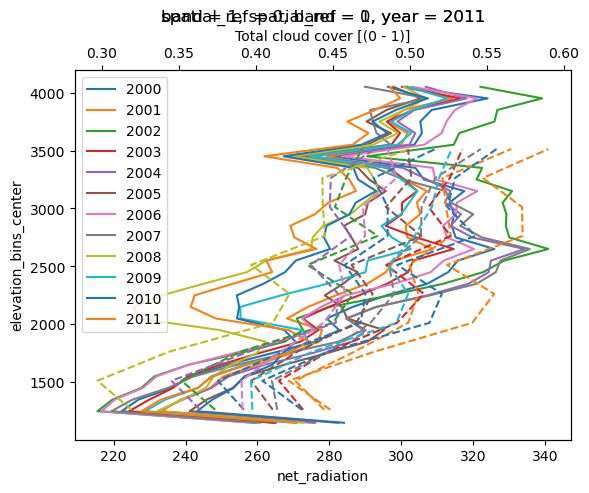

In [31]:
fig, ax = plt.subplots()
ax2 = ax.twiny()
for year in binned_et_eo.year.values:
    if year in np.arange(2000,2012):
        (binned_rnet_spring).sel(year=year).plot(y='elevation_bins', ax=ax, label=year)
        binned_cc_spring.sel(year=year).plot(y='elevation_bins', ax=ax2, label=year, ls='--')
ax.legend()

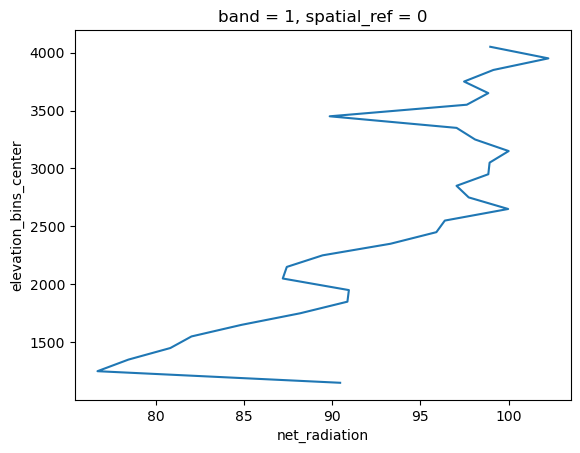

In [32]:
# how does cloud cover relate to rnet during spring?
net_rad = era5_net_matched_ds.where(era5_net_matched_ds.time.dt.month.isin([3,4,5]), drop=True).groupby('time.year').mean()
binned_et_eo = era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).mean().et_eo / 1000
binned_net_rad = net_rad.groupby_bins(net_rad.elevation, bins=np.arange(net_rad.elevation.min(),net_rad.elevation.max(),100)).mean()
binned_net_rad.net_radiation.plot(y='elevation_bins')

Text(0.5, 1.0, 'Area Normalized Total Spring PET')

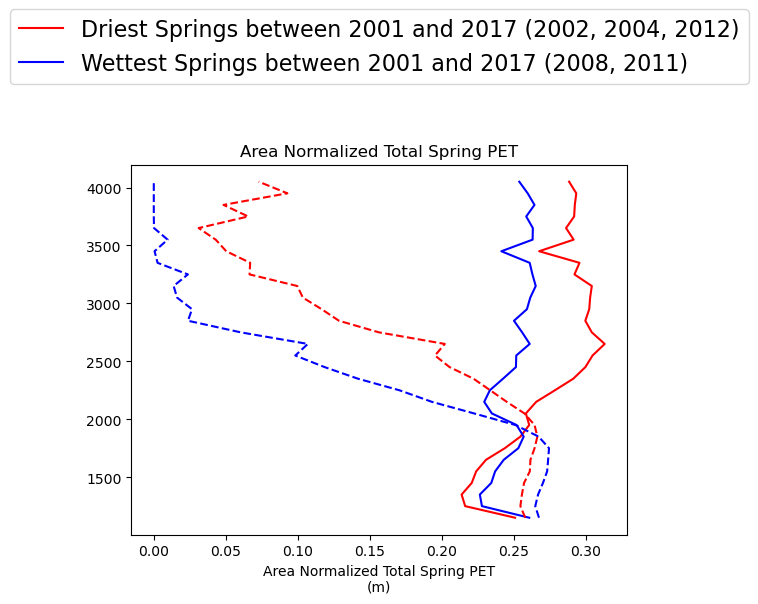

In [37]:
fig, ax = plt.subplots()
binned_et_eo = era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).mean().et_eo / 1000
# binned_et_eo = binned_et_eo * 10130.37725989001 * 10130.37725989001 / 1e9
binned_et_eo.sel(year=[2002,2012]).mean('year').plot(y='elevation_bins',
ax=ax, 
color='r', 
label = 'Driest Springs between 2001 and 2017 (2002, 2004, 2012)')
binned_et_eo.sel(year=[2009, 2011]).mean('year').plot(y='elevation_bins',
ax=ax, 
color='b',
label = 'Wettest Springs between 2001 and 2017 (2008, 2011)')

binned_et_eo = era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).mean().et_eo_adj / 1000
# binned_et_eo = binned_et_eo * 10130.37725989001 * 10130.37725989001 / 1e9
binned_et_eo.sel(year=[2002,2012]).mean('year').plot(y='elevation_bins',
ax=ax, 
color='r', 
ls='--',)
binned_et_eo.sel(year=[2009, 2011]).mean('year').plot(y='elevation_bins',
ax=ax, 
color='b',
ls='--',)


ax.legend(fontsize=16, bbox_to_anchor=(0.5, 1.32), loc='center')
ax.set_xlabel('Area Normalized Total Spring PET\n(m)')
ax.set_ylabel('')
ax.set_title('Area Normalized Total Spring PET')


In [80]:
one = spring_modis_sca.groupby_bins('elevation', np.arange(era5_data.elevation.min(),
                                                    era5_data.elevation.max(),
                                                    100)).mean().Snow_Cover_Extent.sel(year=[2002,2012]).mean('year')
two = spring_modis_sca.groupby_bins('elevation', np.arange(era5_data.elevation.min(),
                                                    era5_data.elevation.max(),
                                                    100)).mean().Snow_Cover_Extent.sel(year=[2009,2011]).mean('year')
(one-two).isel(elevation_bins=slice(13,18)).mean()

<xarray.DataArray 'Snow_Cover_Extent' ()>
array(-0.22178419, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

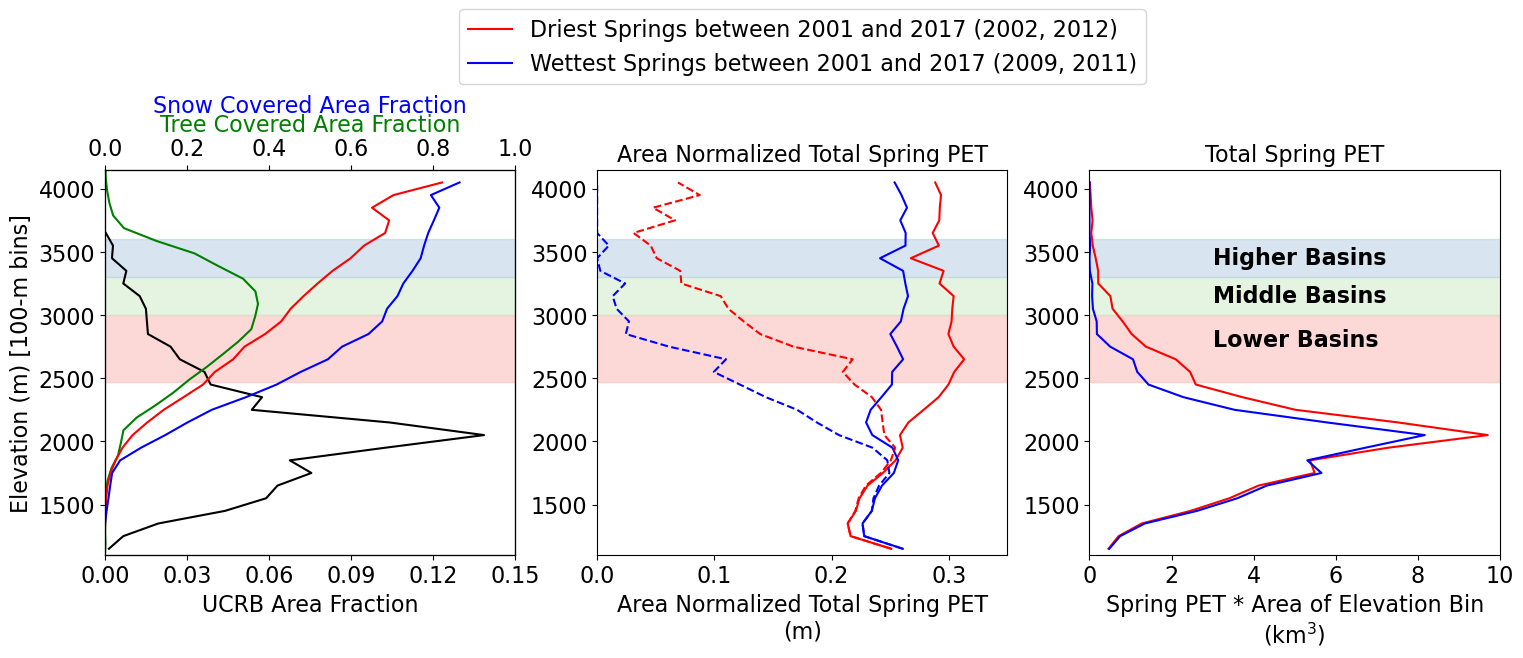

In [79]:
fig, axs = plt.subplots(ncols=3, figsize=(18,5))
ax = axs[0]
((dem_area.groupby_bins('elevation',
                        np.arange(era5_data.elevation.min(),
                                  era5_data.elevation.max(),
                                  100)).sum()).area/(dem_area.groupby_bins('elevation',
                                                                           np.arange(era5_data.elevation.min(),
                                                                                     era5_data.elevation.max(),
                                                                                     100)).sum()).area.sum()).plot(y='elevation_bins', 
                                                                                                                   ax=ax,
                                                                                                                   color='k')
ax.set_xlabel('UCRB Area Fraction')
ax2 = ax.twiny()
tree_covered_area_bins.plot(y='elevation_bins',ax=ax2, color='g')
spring_modis_sca.groupby_bins('elevation', np.arange(era5_data.elevation.min(),
                                                    era5_data.elevation.max(),
                                                    100)).mean().Snow_Cover_Extent.sel(year=[2002,2012]).mean('year').plot(y='elevation_bins',
                                                                                                                                ax=ax2, 
                                                                                                                                color='r', 
                                                                                                                                label='Dry Spring (2002)')
spring_modis_sca.groupby_bins('elevation', np.arange(era5_data.elevation.min(),
                                                    era5_data.elevation.max(),
                                                    100)).mean().Snow_Cover_Extent.sel(year=[2009,2011]).mean('year').plot(y='elevation_bins',
                                                                                                                           ax=ax2, 
                                                                                                                           color='b', 
                                                                                                                           label='Wet Spring (2011)')
ax2.set_xlabel('Tree Covered Area Fraction', color='g', fontsize=16)
# make the ticks green
for tl in ax2.get_xticklabels():
    tl.set_color('k')
    tl.set_fontsize(16)
ax2.tick_params(axis='x', colors='k')
ax2.set_xlim(0,1)
ax2.set_title('')
# add another axis on top of ax2
ax3 = ax.twiny()
ax3.set_xlim(0,1)
ax3.set_xlabel('Snow Covered Area Fraction', color='b', fontsize=16)
# move the xlable up a bit
ax3.xaxis.set_label_coords(0.5, 1.15)
# turn off the ticks and tick labels

ax3.set_xticks([])
ax3.set_xticklabels([])


ax.set_ylabel('Elevation (m) [100-m bins]')
ax.set_title('')
ax.set_xlim(0,0.15)
ax.set_xticks(np.arange(0,0.16,0.03))

ax = axs[1]
# binned_et_eo = binned_et_eo * 10130.37725989001 * 10130.37725989001 / 1e9
binned_et_eo = era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).mean().et_eo / 1000
binned_et_eo.sel(year=[2002,2012]).mean('year').plot(y='elevation_bins',
                                                        ax=ax, 
                                                        color='r', 
                                                        label = 'Driest Springs between 2001 and 2017 (2002, 2012)')
binned_et_eo.sel(year=[2009, 2011]).mean('year').plot(y='elevation_bins',
                                                        ax=ax, 
                                                        color='b',
                                                        label = 'Wettest Springs between 2001 and 2017 (2009, 2011)')
band_diff_1 = binned_et_eo.sel(year=[2002,2012]).mean('year') - binned_et_eo.sel(year=[2009, 2011]).mean('year')

binned_et_eo = era5_data.groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).mean().et_eo_zero / 1000
# binned_et_eo = binned_et_eo * 10130.37725989001 * 10130.37725989001 / 1e9
binned_et_eo.sel(year=[2002,2012]).mean('year').plot(y='elevation_bins',
                                                    ax=ax, 
                                                    color='r', 
                                                    ls='--',)
binned_et_eo.sel(year=[2009, 2011]).mean('year').plot(y='elevation_bins',
                                                    ax=ax, 
                                                    color='b',
                                                    ls='--',)
band_diff_2 = binned_et_eo.sel(year=[2002,2012]).mean('year') - binned_et_eo.sel(year=[2009, 2011]).mean('year')
ax.legend(fontsize=16, bbox_to_anchor=(0.5, 1.32), loc='center')
ax.set_xlabel('Area Normalized Total Spring PET\n(m)')
ax.set_ylabel('')
ax.set_title('Area Normalized Total Spring PET')
ax.set_xlim(0,0.35)


ax = axs[2]
binned_et_eo = era5_data.where(era5_data.elevation>0).groupby_bins(era5_data.elevation, bins=np.arange(era5_data.elevation.min(),era5_data.elevation.max(),100)).sum().et_eo_zero / 1000
binned_et_eo = binned_et_eo * 10130.37725989001 * 10130.37725989001 / 1e9

binned_et_eo.sel(year=[2002, 2012]).mean('year').plot(y='elevation_bins',
                                                            ax=ax, 
                                                            color='r', 
                                                            label = 'Driest Springs (2002, 2012)')
binned_et_eo.sel(year=[2009, 2011]).mean('year').plot(y='elevation_bins',
ax=ax, 
color='b',
label = 'Wettest Spring (2009, 2011)')
ax.set_xlabel('Spring PET * Area of Elevation Bin\n(km$^3$)')
ax.set_ylabel('')
ax.set_title('Total Spring PET')
ax.set_xlim(0,10)
# add a text annotation for the band just above the bottom of the band at 2470 
ax.text(3, 2800,'Lower Basins ', ha='left', va='center', color='black', fontsize=16, weight='bold')
# add a text annotation for the band just above the bottom of the band at 2470 
ax.text(3, 3150,'Middle Basins', ha='left', va='center', color='black', fontsize=16, weight='bold')
# add a text annotation for the band just above the bottom of the band at 2470 
ax.text(3, 3450,'Higher Basins', ha='left', va='center', color='black', fontsize=16, weight='bold')
for ax in axs:
    ax.set_ylim(era5_data.elevation.min(),era5_data.elevation.max())
    # increase the font size for all x and y ticks
    ax.tick_params(axis='both', which='major', labelsize=16)
    # increase the font size for x and y labels
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.set_title(ax.get_title(), fontsize=16)
    # add a horizontal band between 2470 and 2900
    ax.axhspan(2470, 3000, color='#fbb4ae', alpha=0.5,)
    
    # add a horizontal band between 2900 and 3200
    ax.axhspan(3000, 3300, color='#ccebc5', alpha=0.5,)
    
    # add a horizontal band between 3200 and 3600
    ax.axhspan(3300, 3600, color='#b3cde3', alpha=0.5,)

# fig.suptitle('Hypsometric Plot of Spring PET (Energy-Only) and Elevation', fontsize=20, y=1.2)

In [72]:
band_diff_2.isel(elevation_bins=slice(19,22))

<xarray.DataArray 'et_eo_adj' (elevation_bins: 3)>
array([0.08733842, 0.08585935, 0.04280961])
Coordinates:
    spatial_ref     int64 0
    band            int64 1
  * elevation_bins  (elevation_bins) object (3000.4, 3100.4] ... (3200.4, 330...

0.10728422712934282
0.07847515209089913
0.03921689836810587


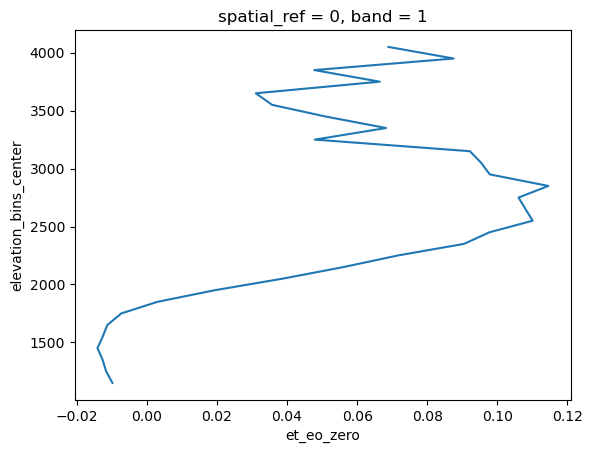

In [82]:
band_diff_2.plot(y='elevation_bins')
print(band_diff_2.isel(elevation_bins=slice(13,18)).mean().values)
print(band_diff_2.isel(elevation_bins=slice(19,22)).mean().values)
print(band_diff_2.isel(elevation_bins=slice(23,26)).mean().values)